In [25]:
import numpy as np  
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import sep
from reproject import reproject_interp
from astropy.coordinates import SkyCoord
from astropy import units as u

In [ ]:
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)

### Factor F

In [3]:
GAIAspectrum = fits.open('GAIA3_509862066010920960.fits')

def Factor(filtro):

    file_name = f"{filtro}_trasmission.txt"

    r_trasm = Table.read(file_name, format='ascii.basic')
    r_wave=r_trasm["Wavelength(A)"]
    r_value=r_trasm["Transmission(QE*Filter)"]

    r_trasm_new=np.interp(GAIAspectrum[1].data, r_wave, r_value)

    x=GAIAspectrum[1].data
    y_filter=r_trasm_new
    y_spectrum=np.array(GAIAspectrum[0].data)

    Num = np.trapz(y_spectrum * y_filter, x)
    Den= np.trapz(y_filter, x)
    return Num/Den           # Factor for the flux

### Bias 
Independent on anything 


In [ ]:
def bias():
    Grid=[]
    path=os.getcwd()+'/bias'
    for file in os.listdir(path):
        fitsfile=fits.open(path+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    return np.mean(Grid, axis=0)

# it is the same for all the images 
#masterbias=bias()

### Flat

In [ ]:
def flat(filtro):   
    pathf=os.getcwd()+f"/{filtro}FLAT"
    
    Grid=[]
    for file in os.listdir(pathf):
        fitsfile=fits.open(pathf+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)
    master=np.median(Grid, axis=0)-bias()
    
    return master/np.median(master)

#masterflat=flat('R')
#print(masterflat)

### Dark current

In [ ]:
def dark_current(exptime):

    pathd=os.getcwd()+'/DARK'+f'{exptime}'
    Grid=[]
    for file in os.listdir(pathd):
        fitsfile=fits.open(pathd+'/'+file)
        dati = fitsfile[0].data
        Grid.append(dati)

    master=np.median(Grid, axis=0)-bias()
    return master

#mastercurrent=dark_current('300')

In [148]:
def background(data2, pixpos):

    data_cut = data2[1700:1800,2400:2500]
    position = pixpos[0]-2400, pixpos[1]-1700  # (x, y) position of the star in the cutout

    ap = CircularAperture(position, r=15)
    photo_inside = aperture_photometry(data_cut,ap)
    final_flux = photo_inside[0][3:]

    annulus_ap=CircularAnnulus(position, r_in=20, r_out=30)
    aperstats= ApertureStats(data_cut, annulus_ap)
    bkg_mean=aperstats.mean

    aperture_area=ap.area
    total_bkg=bkg_mean*aperture_area
    
    return final_flux - total_bkg


In [149]:
def DataProcess(filtro, exptime):

    Path = os.path.join(os.getcwd(), 'DATA', filtro)
    masterbias=bias()
    mastercurrent=dark_current(exptime)
    masterflat=flat(filtro)

    c = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))

    ref_wcs =  WCS(naxis=2)

    ref_wcs.wcs.crval =[c.ra.degree, c.dec.degree]
    ref_wcs.wcs.crpix =[3500/2.0, 3500/2.0]  
    ref_wcs.wcs.ctype =["RA---TAN", "DEC--TAN"] 
    ref_wcs.wcs.cunit=["deg", "deg"]

    #trasformation of 0.55 arcsec/pixel
    dim_degrees= (0.55/3600.0)

    ref_wcs.wcs.cd= np.array([[-dim_degrees, 0.0], [0.0, dim_degrees]])
    all_images=[]

    for file in os.listdir(Path):       #for all the file in the filter of a given day

        if not file.lower().endswith('.fits'):
            continue

        Fitsfile=fits.open(Path+'/'+file)

        #read the data 
        Data = Fitsfile[0].data

        #coordinates of the image
        wcs = WCS(Fitsfile[0].header)

        data1 = (Data-masterbias-mastercurrent)/masterflat
        data2=data1*0.25/300                                    # to have the flux in e-/s     
        
        pixpos = wcs.wcs_world2pix(23.38804096055661,60.63702187961969, 1)         #coordinates of the star for calibration
        
        Calibration_costant=Factor(filtro)/background(data2, pixpos)

        data=data2-np.median(data2)
        std=np.std(data2)
        objects, map = sep.extract(data, 2, err=std, segmentation_map=True)              #return an image 


        bkg = sep.Background(data, mask=map, bw=64, bh=64, fw=12, fh=12)
        Final=data2-bkg

        #reproject the image 
        new_repr= reproject_interp((Final, wcs), ref_wcs, shape_out=(3500,3500))
        all_images.append(new_repr[0])
        #print(new_repr[0])

        #plt.imshow(new_repr[0], vmin=mean_f-2*std_f,vmax=mean_f+2*std_f,cmap='gray', origin='lower')
        #plt.show()
        #print("ok")

    return np.mean(all_images, axis=0)          #choose the correct axis 

In [150]:
Result=DataProcess('R','300')
print(Result)

[[       nan        nan        nan ... 8.92986638 8.88793225 8.84949402]
 [       nan        nan        nan ... 8.91741854 8.91138473 8.84701593]
 [       nan        nan        nan ... 8.91820949 8.95284356 8.93539608]
 ...
 [8.89864023 8.93496246 8.91179809 ...        nan        nan        nan]
 [8.90887001 8.88404034 8.86959486 ...        nan        nan        nan]
 [8.94529345 8.91733047 8.88283559 ...        nan        nan        nan]]


In [151]:
Result_mean = np.nanmean(Result)  # ignora i NaN
Result_std  = np.nanstd(Result)   # ignora i NaN

print(Result_mean)
print(Result_std)

8.93859504743483
0.6038748421418584


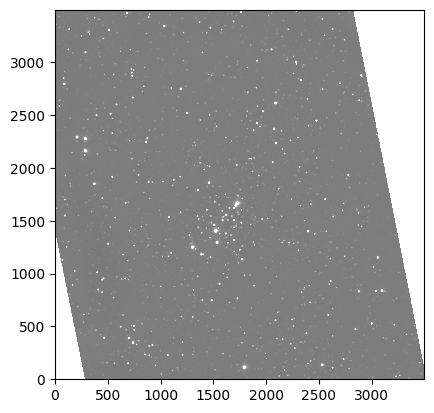

In [152]:
plt.imshow(Result, vmin=Result_mean-2*Result_std, vmax=Result_mean+2*Result_std, cmap='gray', origin='lower')

8.764346882591596
0.6081158133853883


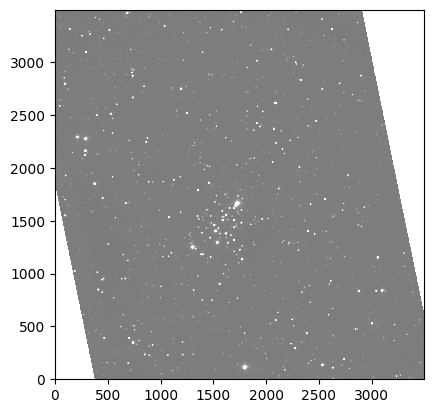

In [153]:
#run other filter 
Result2=DataProcess('G','300')
Result_mean2 = np.nanmean(Result2)  # ignora i NaN
Result_std2  = np.nanstd(Result2)   # ignora i NaN
print(Result_mean2)
print(Result_std2)
plt.imshow(Result2, vmin=Result_mean2-2*Result_std2, vmax=Result_mean2+2*Result_std2, cmap='gray', origin='lower')